In [413]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm as tqdm
import numpy as np

In [414]:
data = pd.read_csv("data.csv")
data = data.dropna()
for i in range(0,data.shape[0]):
    data['fpl_sel'].iloc[i] = float(str(data['fpl_sel'].iloc[i]).rstrip('%'))
data['fpl_sel'] = data['fpl_sel'].astype('float64')
print(data.dtypes)
data.head

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


name             object
club             object
age               int64
position         object
position_cat      int64
market_value    float64
page_views        int64
fpl_value       float64
fpl_sel         float64
fpl_points        int64
region          float64
nationality      object
new_foreign       int64
age_cat           int64
club_id           int64
big_club          int64
new_signing       int64
dtype: object


<bound method NDFrame.head of                     name      club  age position  position_cat  market_value  \
0         Alexis Sanchez   Arsenal   28       LW             1          65.0   
1             Mesut Ozil   Arsenal   28       AM             1          50.0   
2              Petr Cech   Arsenal   35       GK             4           7.0   
3           Theo Walcott   Arsenal   28       RW             1          20.0   
4      Laurent Koscielny   Arsenal   31       CB             3          22.0   
..                   ...       ...  ...      ...           ...           ...   
456  Edimilson Fernandes  West+Ham   21       CM             2           5.0   
457       Arthur Masuaku  West+Ham   23       LB             3           7.0   
458            Sam Byram  West+Ham   23       RB             3           4.5   
459      Ashley Fletcher  West+Ham   21       CF             1           1.0   
460         Diafra Sakho  West+Ham   27       CF             1          10.0   

     page

In [415]:
#data['page_views'] = np.sqrt(data['page_views'])
#data['fpl_sel'] = np.sqrt(data['fpl_sel'])

In [416]:
print(data['page_views'].quantile(0.90))
data["page_views"] = np.where(data["page_views"] <1713.4, 1713.4,data['page_views'])
print(data['fpl_sel'].quantile(0.90))
data["fpl_sel"] = np.where(data["fpl_sel"] <10.4, 10.4,data['fpl_sel'])

1713.400000000001
10.4


In [417]:
import numpy as np
X = data[data.columns[~data.columns.isin(['market_value'])]]
y = data['market_value']

from sklearn.model_selection import train_test_split
np.random.seed(37) # Set seed
x_train, x_test = train_test_split(X, test_size = 0.15, random_state = 40 )

## dont using iloc as we have projected from data
y_train = y.loc[x_train.index.values] 
y_test = y.loc[x_test.index.values]
x_train = X.loc[x_train.index.values, :]
x_test = X.loc[x_test.index.values, :]

In [418]:
concat_train_data = pd.concat([x_train,y_train],axis=1)
x_train = x_train.dropna()
x_train = x_train.drop(['position','name','age','club','nationality'], axis = 1)
#scaling
from sklearn.preprocessing import StandardScaler
scaler =StandardScaler()
scaled_data = scaler.fit_transform(x_train)
#print(scaler.transform(concat_train_data))
scaled_data.shape

(391, 11)

In [419]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=11)
pca.fit(scaled_data)
print(pca.explained_variance_)
print(np.cumsum(pca.explained_variance_ratio_*100))

[2.75072243 1.39494706 1.32698917 1.08215631 0.98875446 0.9204883
 0.76665807 0.69144442 0.54600807 0.4097055  0.15033134]
[ 24.94261216  37.59151596  49.62420086  59.43682491  68.40251288
  76.74918657  83.7009803   89.97076227  94.92177707  98.6368467
 100.        ]


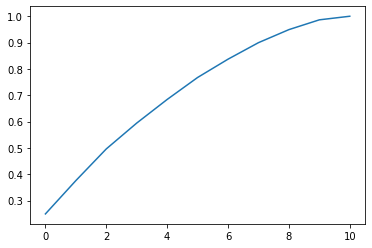

In [420]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()


In [421]:
print(np.cumsum(pca.explained_variance_ratio_*100)[8])

94.92177706625324


In [422]:
print(np.cumsum(pca.explained_variance_ratio_*100)[9])

98.6368467049611


In [423]:
pca = PCA(n_components=11)
pca.fit(scaled_data)

PCA(n_components=11)

In [424]:
np.cumsum(pca.explained_variance_ratio_*100)

array([ 24.94261216,  37.59151596,  49.62420086,  59.43682491,
        68.40251288,  76.74918657,  83.7009803 ,  89.97076227,
        94.92177707,  98.6368467 , 100.        ])

In [425]:
from sklearn.linear_model import LinearRegression
X = pca.transform(scaled_data)
y = y_train
reg = LinearRegression().fit(X, y)
reg.score(X, y) 

0.7543535596770261

In [427]:
x_test = x_test.drop(['position','name','age','club','nationality'], axis = 1)
scaled_data_test = scaler.fit_transform(x_test)
test_data = pca.transform(scaled_data_test)
pred = reg.predict(test_data)

In [429]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,pred)

24.99831745537082

In [430]:
import sklearn
sklearn.metrics.r2_score(y_test, pred, sample_weight=None, multioutput='uniform_average')

0.8326970317028723

In [406]:
pred = reg.predict(X)
mean_squared_error(y,pred)

36.895187938506716